# Dependencies and Setup

In [202]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gmaps
from api_keys import g_key
%matplotlib inline

In [203]:
# Read from csv 
drug_related_deaths_df = pd.read_csv('../Datasets/Accidental_Drug_Related_Deaths_2012-2018.csv')

In [204]:
# Removing unnecessary columns
narrowed_df = drug_related_deaths_df.loc[:,['ID','Date','Age','Sex','Race','DeathCity','DeathCityGeo','COD','Heroin','Cocaine','Fentanyl','FentanylAnalogue','Oxycodone','Oxymorphone','Ethanol','Hydrocodone','Benzodiazepine','Methadone','Amphet','Tramad','Morphine_NotHeroin','Hydromorphone','Other','OpiateNOS','AnyOpioid']]

# Drop records without Age, Sex and Race entry
narrowed_df = narrowed_df.dropna(subset=['Age', 'Sex','Race'], how='all')

# Fill NaN values by N
narrowed_df.update(narrowed_df[['Heroin','Cocaine','Fentanyl','FentanylAnalogue','Oxycodone','Oxymorphone','Ethanol','Hydrocodone','Benzodiazepine','Methadone','Amphet','Tramad','Morphine_NotHeroin','Hydromorphone','Other','OpiateNOS','AnyOpioid']].fillna('N'))

# Convert date column to Datetime object
narrowed_df['Date'] = pd.to_datetime(narrowed_df['Date'])
narrowed_df

narrowed_df.to_csv('../Datasets/Reduced_DataSet.csv')

In [205]:
# Get count of deaths in each month
narrowed_df.index = pd.to_datetime(narrowed_df['Date'],format='%m/%d/%y %I:%M%p')
deaths_by_year_month_df = narrowed_df.groupby(by=[narrowed_df.index.year,narrowed_df.index.month]).agg({'ID':'count'})

In [206]:
# Create new dataframe with year,month and day concatenated
deaths_per_months_df = pd.DataFrame(columns=['Month', 'Deaths Per Month'])
for index, row in deaths_by_year_month_df.iterrows():
    year = int(index[0])
    month = int(index[1])
    day = 1
    count = row[0]
    
    converted_date = datetime(year,month,day)
    deaths_per_months_df = deaths_per_months_df.append({'Month': converted_date, 'Deaths Per Month': count}, ignore_index=True)  

In [207]:
# Set index as month to plot Deaths per month chart
deaths_per_months_df.set_index('Month', inplace=True)
deaths_per_months_df.head()

,Deaths Per Month
Month,
2012-01-01,31
2012-02-01,27
2012-03-01,24
2012-04-01,30
2012-05-01,28


Text(0, 0.5, 'Drug Related Deaths')

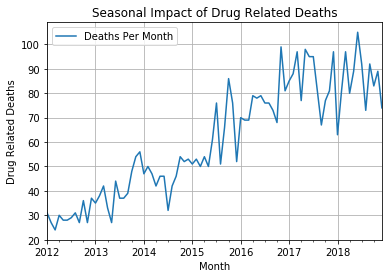

In [170]:
start_date = datetime(2012,1,1)
end_date = datetime(2018,12,1)

deaths_per_months_df[(start_date <= deaths_per_months_df.index) & (deaths_per_months_df.index <= end_date)].plot(grid='on')
plt.title('Seasonal Impact of Drug Related Deaths')
plt.ylabel('Drug Related Deaths')

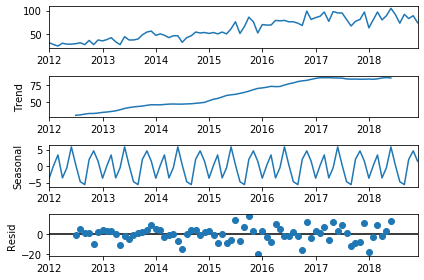

In [171]:
decomposition = sm.tsa.seasonal_decompose(deaths_per_months_df,model='additive')
fig = decomposition.plot()

In [193]:
narrowed_df.head()

,ID,Date,Age,Sex,Race,DeathCity,DeathCityGeo,COD,Heroin,Cocaine,...,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-21,13-0102,2013-03-21,48.0,Male,Black,NORWALK,"Norwalk, CT\n(41.11805, -73.412906)",Cocaine Intoxication,N,Y,...,N,N,N,N,N,N,N,N,N,N
2016-03-13,16-0165,2016-03-13,30.0,Female,White,DANBURY,"Danbury, CT\n(41.393666, -73.451539)",Acute Heroin and Cocaine Intoxication,Y,Y,...,N,N,N,N,N,N,N,N,N,Y
2016-03-31,16-0208,2016-03-31,23.0,Male,White,GREENWICH,"Greenwich, CT\n(41.026526, -73.628549)",Acute Fentanyl and Morphine Intoxication,Y,N,...,N,N,N,N,N,N,N,N,N,Y
2013-02-13,13-0052,2013-02-13,22.0,Male,"Asian, Other",GREENWICH,"Greenwich, CT\n(41.026526, -73.628549)",Fentanyl Intoxication,N,N,...,N,N,N,N,N,N,N,N,N,N
2014-06-29,14-0277,2014-06-29,23.0,Male,White,BRISTOL,"BRISTOL, CT\n(41.673037, -72.945791)",Heroin Intoxication,Y,N,...,N,N,N,N,N,N,N,N,N,N


In [191]:
# Get count of deaths per city - as weights for heatmap
deaths_by_city = narrowed_df.groupby(['DeathCity']).agg({'ID':'count'})
deaths_by_city = deaths_by_city.rename(columns={"ID": "Deaths Per City"})

,Deaths Per City
DeathCity,
06340,1
AMSTON,1
ANDOVER,3
ANSONIA,23
ASHFORD,6
...,...
WINSTED,12
WOLCOTT,2
WOODBRIDGE,4


In [192]:
# coordinates = narrowed_df.DeathCityGeo.str.split("\n")[1][1]
lattitude = []
longitude = []

for index, row in narrowed_df.iterrows():
    lat_lng = row[6].split("\n")[1]
    
    # Fetch lat and lng coordinates 
    lat = lat_lng[lat_lng.find('4'):lat_lng.find(',')]
    lng = lat_lng[lat_lng.find('-'):lat_lng.find(')')]
    
    lattitude.append(float(lat))
    longitude.append(float(lng))
    
coordinates = list(zip(lattitude,longitude))

In [186]:
# Configure gmaps.
gmaps.configure(api_key=g_key)

figure_layout = {
    'width': '800px',
    'height': '400px',
    'border': '1px solid black',
    'padding': '1px',
    'margin':'0 auto 0 auto'
}

fig = gmaps.figure(layout=figure_layout)

markers = gmaps.heatmap_layer(coordinates)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='400px', margin='0 auto 0 auto', padding='1px', wi…